## Basic setup

In [43]:
%run env_setup.py
%matplotlib inline
from __future__ import division,print_function
from importlib import reload
import numpy as np
import os
from glob import glob
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import keras
import lessdeep.utils.display as dis

## Download and setup

**you can change the data and the batch size to fit the model to other datasets**

In [3]:
# Download
from lessdeep.datasets.kaggle import dog_cat
from lessdeep.datasets.kaggle import downloader

datapath = dog_cat.download_data()

Enter your user name:········
Enter your Password:········
D:\learn\online_course\notes\_data\kaggle\dog_cat\_cache\train.zip already downloaded !
D:\learn\online_course\notes\_data\kaggle\dog_cat\_cache\test1.zip already downloaded !


In [4]:
## setup working data path
path = datapath
sample_path = os.path.join(path, 'sample')

In [5]:
## As large as you can, but no larger than 64 is recommanded
batch_size = 64

## Create model

In [98]:
# Generate vgg model
import lessdeep.model.vgg16
reload(lessdeep.model.vgg16)
from lessdeep.model.vgg16 import Vgg16

vgg = Vgg16()

## Load data(Batches)
- accept data path contain at least two folder
    - train
    - valid
- each subfolder contain images in each folder with the class name

In [99]:
# depends on the variable datapath
batches = vgg.get_batches(os.path.join(datapath, 'train'), batch_size=batch_size)
val_batches = vgg.get_batches(os.path.join(datapath, 'valid'), batch_size=batch_size)

# get batch labels
def onehot(batch_classes):
    from sklearn.preprocessing import OneHotEncoder
    return np.array(OneHotEncoder().fit_transform(batch_classes.reshape(-1, 1)).todense())

train_onehot = onehot(batches.classes)
val_onehot = onehot(val_batches.classes)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Finetune

In [100]:
vgg.finetune(batches)

## Test on sample

In [10]:
smp_batches = vgg.get_batches(os.path.join(sample_path, 'train'), batch_size=batch_size)
smp_val_batches = vgg.get_batches(os.path.join(sample_path, 'valid'), batch_size=batch_size)
smp_imgs, smp_labels = smp_val_batches.next()

Found 20 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


Epoch 1/1
1/1 [==============================] - 0s - loss: 1.0363 - acc: 0.6000 - val_loss: 0.6690 - val_acc: 0.6250


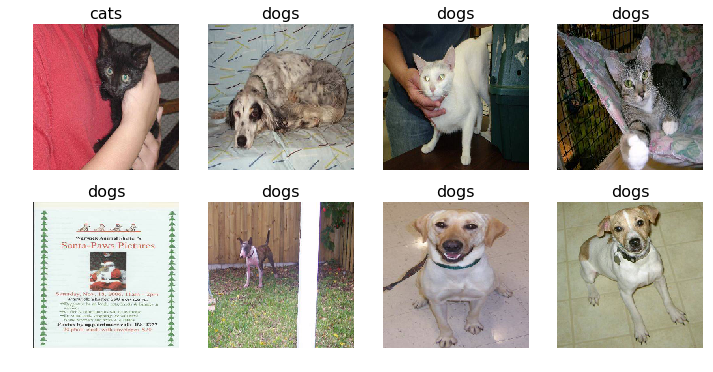

In [13]:
sample_num = 8
sample_epochs = 1

vgg.fit(smp_batches, smp_val_batches, epochs=sample_epochs)

preds, idxs, classes = vgg.predict_data(smp_imgs[:sample_num])
dis.imshow(Vgg16.img_cvt(smp_imgs[:sample_num]), titles=classes[:sample_num], rows=2)

In [80]:
vgg.model.compile(keras.optimizers.RMSprop(lr=0.001), loss='categorical_crossentropy',
                           metrics=['accuracy'])
#vgg.model.load_weights('opt0.h5')
#vgg.compile()

## Start train

In [81]:
epochs = 1
vgg.fit(batches, val_batches, epochs=epochs)

Epoch 1/1
718/718 [==============================] - 155s - loss: 0.4706 - acc: 0.8892 - val_loss: 0.2720 - val_acc: 0.9253


In [110]:
def predict(batches, prefix='last', save_to_dir='_cache', save_format='jpeg'):
    old_save_dir = batches.save_to_dir
    old_save_prefix = batches.save_prefix
    old_save_format = batches.save_format
    old_shuffle = batches.shuffle
    batches.save_to_dir = save_to_dir
    batches.save_prefix = prefix
    batches.save_format = save_format
    batches.shuffle = False
    os.makedirs(val_batches.save_to_dir, exist_ok=True)
    
    files = glob(os.path.join(save_to_dir, '{prefix}_*.{format}'.format(prefix=prefix, format=save_format)))
    print('remove' + str(len(files)))
    for f in files:
        os.remove(f)
    
    res = vgg.predict(batches, verbose=1)
    
    batches.save_to_dir = old_save_dir
    batches.save_prefix = old_save_prefix
    batches.save_format = old_save_format
    batches.shuffle = old_shuffle
    
    return res

def image_cache(index, prefix='last', save_to_dir='_cache', save_format='jpeg'):
    files = glob(os.path.join(save_to_dir, '{prefix}_{index}_*.{format}'.format(prefix=prefix,
                                                                        index=index,
                                                                        format=save_format)))
    if len(files) < 1:
        raise RuntimeError("Cannot find cached image in folder:" + save_to_dir)
    elif len(files) != 1:
        raise RuntimeError("More than one image:" + str(files))

    return files[0]
probs, preds, classes = predict(val_batches)

remove2000
62/62 [==============================] - 14s    


In [18]:
vgg.save_weights('opt0.h5')

In [112]:
help(vgg.model.model.predict_generator)
c1 = val_batches.classes
c1

Help on method predict_generator in module keras.engine.training:

predict_generator(generator, steps, max_q_size=10, workers=1, pickle_safe=False, verbose=0) method of keras.engine.training.Model instance
    Generates predictions for the input samples from a data generator.
    
    The generator should return the same kind of data as accepted by
    `predict_on_batch`.
    
    # Arguments
        generator: Generator yielding batches of input samples.
        steps: Total number of steps (batches of samples)
            to yield from `generator` before stopping.
        max_q_size: Maximum size for the generator queue.
        workers: Maximum number of processes to spin up
            when using process based threading
        pickle_safe: If `True`, use process based threading.
            Note that because
            this implementation relies on multiprocessing,
            you should not pass
            non picklable arguments to the generator
            as they can't be pa

array([0, 0, 0, ..., 1, 1, 1])

## Bad result

In [66]:
def show_bad(class_idx, shape=(2,4)):
    from keras.preprocessing.image import load_img
    bad = np.where(preds != val_onehot[:, class_idx])[0]
    bad_select = np.random.choice(bad, min(shape[0]*shape[1], len(bad)), replace=False)
    print(np.where(preds != val_onehot[:, class_idx]))
    dis.imshow([load_img(image_cache(i)) for i in bad_select],
               titles=probs[bad_select])
#show_bad(1)

len(preds)
#len(val_onehot[:, 0])

1968

In [ ]:
val_batches

## Good result

# Submit reuslt

In [69]:
from IPython.display import FileLink
FileLink('data/redux/subm98.csv')

D:\dev\learn\learning_notes\lessdeep\note_tpl\data\redux\subm98.csv